In [3]:
%reload_ext autoreload
%autoreload 2
%reload_ext line_profiler

In [4]:
import pandas as pd
import numpy as np
import pulp
import random
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath("C:\\Users\\Christophe GOUDET\\Documents\\Programmes\\RoomOptimisation"))
from LibRoomOptimisation import CreatePersoData, CreateOfficeData

In [27]:
officeProp = {'roomID':range(4),
             'isLeft':range(2),
              'wc': [0,0,0,0,1],
              'clim': [0,0,0,0,1],
              'mur': [0,0,0,0,1],
              'passage': [0,0,0,0,1],
              'sonnerie': [0,0,0,0,1],
              'window': [0,0,0,0,1],
              'etage' : [1,2],    
             }
officeData = CreateOfficeData(nOffice=20,properties=officeProp)
officeData.head()

,roomID,isLeft,wc,clim,mur,passage,sonnerie,window,etage
officeID,,,,,,,,,
0,0,0,0,0,1,0,1,0,2
1,1,0,0,1,0,0,1,0,1
2,2,0,0,0,0,1,0,0,2
3,3,0,0,0,0,0,0,0,2
4,3,1,0,1,0,0,1,1,1


In [57]:
dicColumnsPerso = {'Nom':str,
                   'Service' :str,
                   'isTall' : bool,
                   'clim' : np.int8,
                   'mur' : np.int8,
                   'passage' : np.int8,
                   'sonnerie' : np.int8,
                   'wc' : np.int8,
                   'weightEtage' : np.int8,
                   'window' :np.int8,
                   'etage' : np.int8,
                   'perso1' : str,
                   'weightPerso1' : np.int8,
                   'perso2' : str,
                   'weightPerso2' : np.int8,
                   'perso2' : str,
                   'weightPerso2' : np.int8,
                  }

In [26]:
np.random.seed(12435)
preferences =  ['clim', 'mur', 'passage', 'sonnerie', 'wc', 'weightEtage', 'window'] + ['weightPerso%i'%i for i in range(1,4)] 
persoData = CreatePersoData( nPerso=10, preferences=options)
persoData.head()

,Nom,services,isTall,clim,mur,passage,sonnerie,wc,weightEtage,window,weightPerso1,weightPerso2,weightPerso3,etage,perso1,perso2,perso3
0,Dummy0,RH,0,9,8,0,6,7,3,5,0,10,4,1,,Dummy7,Dummy5
1,Dummy1,SI,0,0,3,5,6,10,7,4,9,8,2,1,Dummy1,Dummy7,Dummy1
2,Dummy2,GRC,0,9,8,0,10,0,0,7,0,0,0,0,,,
3,Dummy3,RH,1,0,9,3,7,4,5,2,10,6,8,2,Dummy7,Dummy3,Dummy2
4,Dummy4,Achat,0,4,10,0,0,8,7,0,6,9,5,2,Dummy2,Dummy5,Dummy7


officeOccupancy represent the placement variable. 

$$ \text{officeOccupancy}_{p,o} = \begin{cases} 1 &\text{if person p is seated in office o}\\ 0 &\text{otherwise}\end{cases} $$


In [20]:
#Creating variables
officeOccupancy = pulp.LpVariable.matrix("officeOccupancy"
                                         ,(list(persoData.index), list(officeData.index))
                                         ,cat='Binary')

$$ \delta_{s,r} = \begin{cases} 1 &\text{if at least one person of service s is seating in room r}\\ 0 &\text{otherwise}\end{cases} $$


In [21]:
#Creating delta variables
delta = pulp.LpVariable.matrix("delta"
                                ,(np.arange(NServ), np.arange(NRooms))
                                ,cat='Binary')


The purpose of R is to filter the offices which belong to a given bloc of offices. In a given column, which represent a room, the 1 represent the offices which belong to this room.

$$ R_{o,r} = \begin{cases} 1 &\text{if office o belongs to room r}\\ 0 &\text{otherwise}\end{cases} $$

$$XR$$ will represent the number of persons in each room

In [22]:
R = pd.pivot_table(officeData, values=['isLeft'], columns='roomID', index=officeData.index, aggfunc='count').fillna(0).astype(int).values
R

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

The purpose of S is to filter the persons according to their services. Each line represent the list of services in which the given person belongs to.

$$ S_{p,s} = \begin{cases} 1 &\text{if person p belongs to service s}\\ 0 &\text{otherwise}\end{cases} $$

$$SX$$ represent the service distribution accross offices.

In [23]:
S = pd.pivot_table(persoData, values='isTall', columns='service', index=persoData.index, aggfunc='count').fillna(0).astype(int).values.T
S

array([[1, 0, 1, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 1],
       [0, 1, 0, 0, 0, 1, 0, 0]])

Linear programming does not accept 'if then' structure, needed for the definition of $\delta$. 
Instead, the structure will be mocked using the sum of person from a service in a given room ($\Delta$).
    
$\Delta_{s,r}$ represents the number of persons from service s seated in room r. 
It can be computed wit the formula $ \Delta = S.\text{officeOccupancy}.R $.


$$ \delta_{s,r} = \begin{cases} 1 &\text{if } \Delta_{s,r}>0\\ 0 &\text{otherwise}\end{cases} $$

This conditional values of $\delta$ are equivalent of the following set of linear constraints :
$$\delta \geq \frac{\Delta}{K} $$
$$\delta \leq \Delta$$
with $K$ the largest value that $\Delta$ can take : the total amount of person to seat.

In [24]:
Delta = np.dot(np.dot(S, officeOccupancy),R)
#Delta

T represent the room distribution of tall people.

$$ T_{p} = \begin{cases} 1 &\text{if person p is tall}\\ 0 &\text{otherwise}\end{cases} $$



In [25]:
T = pd.pivot_table(persoData, columns='isTall', values='service', index=persoData.index, aggfunc='count').fillna(0).astype(int).values.T[1]
T

array([0, 0, 0, 0, 0, 0, 0, 1])

L filters the offices in each room according the their leftiness or rightness.

$$ L_{o,lr} = \begin{cases} 1 &\text{office o belongs to room r with leftiness l}\\ 0 &\text{otherwise}\end{cases} $$


In [26]:
L = pd.pivot_table(officeData, columns=['isLeft', 'roomID'], values=['dum'], index=officeData.index, aggfunc='count').fillna(0).astype(int).values
L

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1]])

Similarly to $\Delta$, legs represents the number of tall people who occupy a left or right office in a given room.

In [27]:
legs = np.dot(np.dot(T,officeOccupancy),L)
legs

array([1*officeOccupancy_7_0 + 1*officeOccupancy_7_2 + 0,
       1*officeOccupancy_7_4 + 1*officeOccupancy_7_6 + 0,
       1*officeOccupancy_7_10 + 1*officeOccupancy_7_8 + 0,
       1*officeOccupancy_7_1 + 1*officeOccupancy_7_3 + 0,
       1*officeOccupancy_7_5 + 1*officeOccupancy_7_7 + 0,
       1*officeOccupancy_7_11 + 1*officeOccupancy_7_9 + 0], dtype=object)

In [28]:
model = pulp.LpProblem("Office setting maximizing happyness", pulp.LpMaximize)


#Objective function : maximising the number of people seated (constrained anyway)
model += pulp.lpSum( officeOccupancy ) + np.sum(delta)

#Each perso is set once
for s  in np.sum(officeOccupancy, axis=0) :
#    print(s)
    model += s <= 1
    
#Each room is set at least once
for s in np.sum(officeOccupancy, axis=1) :
#    print(s)
    model += s == 1
        
#Constraint of delta
for s in range( NServ) :
    for j in range( NRooms ) :
        model += delta[s][j] >= Delta[s][j]/len(persoData)
        model += delta[s][j] <= Delta[s][j]
        
#We imose two tall people not to be in front of each other
for l in legs :
    model += l <=1

In [29]:
model.solve()
pulp.LpStatus[model.status]

'Optimal'

In [30]:
#Print results
x = []
y = []
t = []
for iPerso in persoData.index :
    for iRoom in officeData.index : 
        if officeOccupancy[iPerso][iRoom].varValue   :
            print( iPerso, iRoom)
            y.append(persoData.loc[iPerso,'service']+1)
            x.append(iRoom)
            t.append(persoData.loc[iPerso, 'isTall'])

0 5
1 0
2 3
3 7
4 6
5 4
6 9
7 2


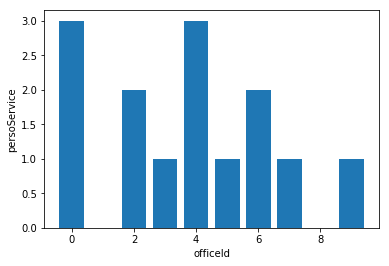

In [31]:
plt.figure()
plt.bar(x,y)
plt.xlabel('officeId')
plt.ylabel('persoService')
plt.savefig('maximiseDispersion.pdf')
plt.show()

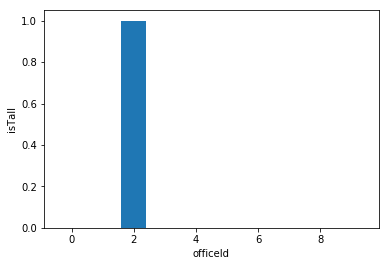

In [32]:
plt.figure()
plt.bar(x,t)
plt.xlabel('officeId')
plt.ylabel('isTall')
#plt.savefig('maximiseDispersion.pdf')
plt.show()

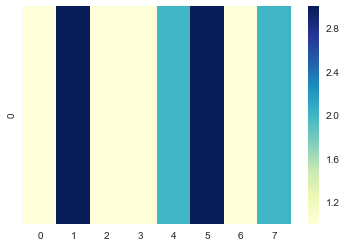

In [40]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
uniform_data = np.random.rand(10, 12)
plt.figure()
ax = sns.heatmap([y],cmap="YlGnBu")
plt.show()

In [24]:
persoData = pd.DataFrame({'etage':[1,0,2], 'weightEtage':[3,8,6], 'window':[0,0,0] })
officeData = pd.DataFrame({'etage':[1,1,2], 'window':[0,1,0], 'dum':[2,4,6]})     


In [25]:
officeFilter = pd.pivot_table(officeData, columns='etage', index=officeData.index, aggfunc=len).fillna(0)
#officeFilter.columns = officeFilter.columns.droplevel()
officeFilter

dum      window     
etage    1    2      1    2
0      1.0  0.0    1.0  0.0
1      1.0  0.0    1.0  0.0
2      0.0  1.0    0.0  1.0

In [36]:
from LibRoomOptimisation import GetPPBinSingleMatching
def SetPPConstraint( model, wish, dispo, pulpMaxVars, pulpBinVars, K ) :
    s = wish.shape
    for i in range(s[0]) :
        for j in range(s[1]) :
#            model += pulpMaxVars[i][j] <= 2 * K + wish[i][j] - 2*K * pulpBinVars[i][j]
#            model += pulpBinVars[i][j] <= dispo[i][j]
#            model += pulpBinVars[i][j] >= dispo[i][j]/K
#            model += pulpMaxVars[i][j] <= K * dispo[i][j]
#            model += pulpMaxVars[i][j] >= - K * dispo[i][j]

In [37]:
persoData = pd.DataFrame({'inPhone':[0, 1, 1], 'weightPhone':[-2, 0, 1] })
officeData = pd.DataFrame({'roomID':[1,0,0]})    
tag='phone'

In [38]:
model = pulp.LpProblem("Office setting maximizing happyness", pulp.LpMaximize)
officeOccupancy = pulp.LpVariable.matrix("officeOccupancy" ,(list(persoData.index), list(officeData.index)),cat='Binary')
(wish, dispo) = GetPPBinMatching( officeOccupancy, officeData, persoData, [tag] )
s = wish.shape
print(s)
pulpMaxVars =  pulp.LpVariable.matrix( 'ppBin', (np.arange(s[0]), np.arange(s[1])), cat='Continuous' )
K = np.fabs(persoData[['weight' + tag[0].upper() + tag[1:]]]).sum()
pulpBinVars =  pulp.LpVariable.matrix( tag+'Bin', (np.arange(s[0]), np.arange(s[1])), cat='Binary' )



(1, 2)


In [39]:
#Each perso is set once
for s  in np.sum(officeOccupancy, axis=0) : model += s <= 1

#Each room is set at least once
for s in np.sum(officeOccupancy, axis=1) : model += s == 1
    
SetPPConstraint( model, wish, dispo, pulpMaxVars, pulpBinVars, K ) 

model.solve()
pulp.value(model.objective)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().